# LDA
- Brigitte Hogan (bwh5v@virginia.edu) & Jason Tiezzi (jbt5am@virginia.edu)  
- DS 5001  
- April 2020  
---


<font color = gray>

## Overview

This notebook creates a topic model the our corpus using the SciKit Learn library. It creates the following tables:

1. `PARAS`, an F1 corpus and reduced version of the DOC table containing only regular nouns. PARAS can be matched to the DOC table using using book_id, chap_num, recp_num and para_num.
2. A Document Term Matrix, `tfv`, a document-term vector space of word counts, also saved in compressed form (`tf`)   
3. DOC-TOPIC, or `THETA`, a language model expansion of VOCAB indicating how much a document likes a topic; can be bound to `DOC` table
4. TOPIC-WORD, or `PHI`, a language model expansion of VOCAB indicating how much a topic likes a word; can be bound to `DOC` table
5. `TOPICS` table of top topics within the corpus; can be bound to THETA or PHI using topic_id
6. An `AUTHOR` table of TOPICS grouped by author
7. A `PERIOD` table of TOPICS grouped by publication period
      
---

# Setup

## Import

#### LDA

In [1]:
import pandas as pd
import pickle                                                        # to save Document Term Matrix
from scipy import sparse                                             # to save csr DTM
from sklearn.feature_extraction.text import CountVectorizer          # creates DTM, doesn't do POS
from sklearn.decomposition import LatentDirichletAllocation as LDA
import os

In [2]:
%matplotlib inline

In [3]:
# For LDA Visualization
import plotly_express as px # comment & clear output below to return Jupyter Lab buttons
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#### Clustering

In [4]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

## Configs

In [5]:
data_dir = 'Tables/' # Cookbook

Although our main interest is at the book, recipe, and paragraph level, it was necessary to retain the chapter level in order to keep recipes separate.

In [6]:
OHCO_full = ['book_id', 'vol_num', 'chap_num', 'recp_num', 'para_num', 'sent_num', 'token_num'] # full cookbook OHCO
OHCO = ['book_id', 'chap_num', 'recp_num', 'para_num']                                          # LDA Cookbook OHCO (drop volume)

Parameters to tune:

In [7]:
n_terms  = 5000 # increased from 4000
n_topics = 25
max_iter = 5

## Define Functions

#### plot_tree()

In [8]:
def plot_tree(PHI, GROUP, metric = 'euclidean', method = 'ward'):
    
    # Get variables
    SIMS = pdist(normalize(PHI), metric=metric)
    TREE = sch.linkage(SIMS, method=method)
    labels  = ["{}: {}".format(a,b) for a, b in zip(GROUP.index, GROUP.topterms.tolist())]
    
    # Plots dendrogram of topics
    plt.figure();
    fig, axes = plt.subplots(figsize=(5, 10));
    dendrogram = sch.dendrogram(TREE, labels=labels, orientation="left");
    plt.tick_params(axis='both', which='major', labelsize=14);

#### get_Topics()

In [9]:
def get_Topics(PHI, THETA):
    TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)
    TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1) # add label column
    TOPICS['doc_weight_sum'] = THETA.sum()
    return TOPICS

#### get_Group()

In [10]:
def get_Group(THETA, LIB, OHCO, TOPICS, n_topics = 30, name = 'author'):
    topic_cols = [t for t in range(n_topics)]
    GROUPS = THETA.join(LIB, on='book_id')\
        .reset_index().set_index([name]+OHCO)\
        .groupby(name)[topic_cols].mean()\
        .T                                            
    GROUPS.index.name = 'topic_id'
    GROUPS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)
    return GROUPS

---
# Prepare Data

## Read in files

In [11]:
TOKENS = pd.read_csv(data_dir + 'TOKEN2.csv')
LIB = pd.read_csv(data_dir + 'LIB.csv').set_index('book_id')
DOC = pd.read_csv(data_dir + 'DOC.csv') # shown for comparison

## Convert TOKENs to PARAS

Creating an F1 style corpus for Scikit Learn using an annotated TOKEN table, keeping only regular nouns.  PARAS is a table of paragraphs.

In [12]:
TOKENS.head()

,book_id,vol_num,chap_num,recp_num,para_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id
0,9935,1,1,1.0,0,0,0,"('1', 'CD')",CD,1,1,14.0
1,9935,1,1,1.0,0,1,0,"('Without', 'IN')",IN,Without,without,16577.0
2,9935,1,1,1.0,0,1,1,"('doubt', 'NN')",NN,doubt,doubt,5252.0
3,9935,1,1,1.0,0,1,3,"('the', 'DT')",DT,the,the,15108.0
4,9935,1,1,1.0,0,1,4,"('greatest', 'JJS')",JJS,greatest,greatest,7253.0


**Taking nouns with a possible 's' at the end.**

In [13]:
PARAS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

In [14]:
PARAS.head()

para_str
book_id chap_num recp_num para_num                                                   
9935    1        1.0      0         doubt problem race food order person life body...
                 2.0      0         principles cooking food refers preparation foo...
                 3.0      0         providing food home matter lot housewife fact ...
                 4.0      0         factor problem food housewife distinction wast...
                          1         connection problem waste leakage household cau...

**PARAS can be matched to DOC using book_id, chap_num, recp_num and para_num, but not all DOC rows have a match in PARAS**

In [15]:
print(DOC.shape)
print(PARAS.shape)

(17176, 6)
(14846, 1)


In [16]:
a = 54568
b = 379
c = 29

DOC[(DOC.book_id == a) & (DOC.recp_num == b) & (DOC.para_num == c)]

,book_id,vol_num,chap_num,recp_num,para_num,para_str
16591,54568,2,37,379.0,29,"""A Guide to Sanitary House Inspection."" W. PAU..."


In [17]:
p2 = PARAS.reset_index()
p2[(p2.book_id == a) & (p2.recp_num == b) & (p2.para_num == c)]

,book_id,chap_num,recp_num,para_num,para_str


In [18]:
del a, b, c, p2

## Create Vector Space

Converting our F1 corpus of paragraphs into a document-term vector space of word counts.

In [19]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english') # Document Term Matrix
tf = tfv.fit_transform(PARAS.para_str)                            # Creates compressed sparse row (csr) Document Term Matrix
TERMS = tfv.get_feature_names()

In [20]:
len(TERMS)

5000

---
# Generate Model

Running Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extracting the THETA and PHI tables.

In [21]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## THETA
Indicates how much a topic likes each document. Topics with higher affinities to particular documents are darker in color. For example, Topic 0 has a strong preference for paragraph 0, recipe 7, chapter 1 in the Women's Institute of Library Cookery, Vol 1 (9935).

In [22]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
THETA.columns.name = 'topic_id'

In [23]:
THETA.shape

(14846, 25)

In [24]:
THETA.head(15).style.background_gradient()

## PHI
Indicates how much a topic likes each word. Darker colors indicate greater affinities to a word. For example, the word 'abbreviations' is favored strongly by Topic 13.

In [25]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [26]:
PHI.T.head(15).style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
term_str,,,,,,,,,,,,,,,,,,,,,,,,,
abbreviations,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,4.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
ability,0.040000,0.044058,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.109296,0.040000,0.040000,0.040000,5.070410,1.040000,3.468859,0.040000,1.507377,0.040000
absence,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,8.039735,0.040000,0.040000,0.040000,1.174620,0.040000,1.040000,0.040000,0.905377,0.040000,0.040000,0.040009,0.040259,0.040000,1.040000,0.040000,0.040000,0.040000,0.040000
absorption,0.040000,0.040000,0.040000,0.040000,1.205903,0.040000,0.040000,0.040000,0.040000,0.693285,0.040000,0.040000,0.040000,0.040000,0.040000,0.544613,0.040000,1.404439,0.040000,0.040000,0.040000,13.351760,0.040000,0.040000,0.040000
abstinence,0.040000,0.040000,2.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.043172,0.040000,0.040000,0.040000,0.040000,0.040000,4.036828,0.040000
abundance,0.040000,0.040000,0.324189,0.040000,0.040000,0.040000,3.917993,0.040000,0.040000,0.040000,0.040308,0.040000,0.040000,3.334615,1.979914,1.040000,0.040000,0.040000,0.253377,0.040000,0.040000,0.040000,0.040000,4.429604,0.040000
acceptation,0.040000,0.040000,1.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,2.040000,0.040000
access,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,3.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,1.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
accessory,0.040000,0.040000,0.040000,0.452662,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.874581,0.040000,0.040000,1.414538,0.040000,0.040000,2.418219,0.040000


---
# Inspect Topics

## Get Top Terms per Topic

Picking out different topics, regardless of book, author, year, etc.

One possible interpretation of the first 3 topics:
- Topic 0: **Making Preserves** (*Fruits*, such as *lemon* and *orange*, are combined with *sugar* and *water* in a *bottle*; the resulting *juice* is strained into *jelly*, which could be served as a *syrup* over *pudding*)
- Topic 1: **A Rich Sauce** (A *sauce* made from *parsley*, *salt*, *pepper*, *butter*, *egg*/*mayonnaise*, and *oysters*, to be served with *lobster*)
- Topic 2: **Flavorful Ingredients** (The following *powdered* *ingredients* may enhance the *flavour* of dishes: *spices*, baking *soda* and *acid* from lemon peel. They might be added as a *relish* along with *oysters* and *sweetbreads*) 

In [27]:
TOPICS = get_Topics(PHI, THETA)

In [28]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,9,label,doc_weight_sum
topic_id,,,,,,,,,,,,
0,juice,sugar,water,lemon,fruit,pudding,orange,jelly,syrup,bottle,0 juice sugar water lemon fruit pudding orange...,544.136575
1,crumbs,parsley,lobster,pepper,sauce,butter,oysters,egg,salt,mayonnaise,1 crumbs parsley lobster pepper sauce butter o...,522.547211
2,powder,oysters,flavour,soda,acid,spice,cook,sweetbreads,ingredients,relish,2 powder oysters flavour soda acid spice cook ...,463.351302
3,knife,lettuce,pieces,skin,dressing,end,way,oil,salad,slices,3 knife lettuce pieces skin dressing end way o...,471.572145
4,food,rice,tea,family,day,diet,foods,value,time,grains,4 food rice tea family day diet foods value ti...,511.401569
5,potatoes,meal,soup,coffee,breakfast,way,carrots,dish,dinner,stock,5 potatoes meal soup coffee breakfast way carr...,531.573741
6,food,water,body,jars,foods,substances,pressure,air,protein,salts,6 food water body jars foods substances pressu...,583.372082
7,water,minutes,salt,boiling,tender,hour,boil,point,pieces,hours,7 water minutes salt boiling tender hour boil ...,768.359249
8,sugar,eggs,water,milk,flour,butter,mixture,egg,salt,pound,8 sugar eggs water milk flour butter mixture e...,1155.443238


## Sort Topics by Doc Weight

Possible interpretation of the top 5 topics:
- Topic 8: **Cake** (Cake is made from a *mixture* of *sugar*, *eggs*, *water*, *flour*, *butter* and *milk*)
- Topic 22: **Gravy** (*Gravy* is made in a *sauce pan* from *butter*, *salt* and *pepper* carefully warmed for several *minutes* while adding *spoonfuls* of *water*)
- Topic 7: **Boiling** (The purpose of *boiling* is so that food becomes *tender*; it is boiled in *pieces* from *minutes* to *hours* with *salt* when *water* reaches its *boiling point*

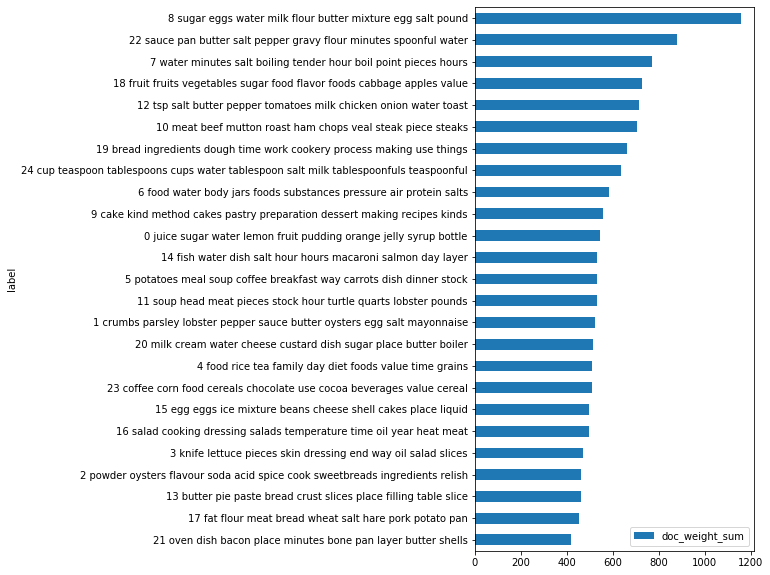

In [29]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10));

In [30]:
names = ['making_preserves','rich_sauce','flavorful_ingredients','food_prep','food_staples','meal_timing','cooking_basics','boiling','cake','dessert','meat','rich_soup','tomato_sauce','pie','fish','more_desserts','salad/meat','generic_recipe','fruits/veggies','bread','custard','oven','gravy','breakfast','measurement']
TOPICS['name'] = names

## Complete list of topic interpretations

- Topic 0: **Making Preserves** (*Fruits*, such as *lemon* and *orange*, are combined with *sugar* and *water* in a *bottle*; the resulting *juice* is strained into *jelly*, which could be served as a *syrup* over *pudding*)
- Topic 1: **A Rich Sauce** (A *sauce* made from *parsley*, *salt*, *pepper*, *butter*, *egg*/*mayonnaise*, and *oysters*, to be served with *lobster*)
- Topic 2: **Flavorful Ingredients** (The following *powdered* *ingredients* may enhance the *flavour* of dishes: *spices*, baking *soda* and *acid* from lemon peel; they might be added as a *relish* along with *oysters* and *sweetbreads*) 
- Topic 3: **Food Prep** (Food preparation involved removing *skin* from meat abd using a *knife* for cutting it into *slices* or separating it into *pieces*; or using *lettuce*, *oil* and *dressing* to make *salad*)
- Topic 4: **Family Staples** (*Food* staples of good *value* for a *family* include *rice*, *grains* and *tea*. These are also important in the *diet* each *day*.)
- Topic 5: **Meal Timing** (*potatoes*, *carrots* and *stock* are common parts of a *soup dish* served at *dinner*, while *coffee* is served at *breakfast*)
- Topic 6: **Cooking Basics** (The processing of *food* in *water*, *air* or *salt*, or preserving in *jars* under *pressure*, keeps *substances* such as *protein* safe for later consumption in the *body*)
- Topic 7: **Boiling** (The purpose of *boiling* is so that food becomes *tender*; it is boiled in *pieces* from *minutes* to *hours* with *salt* when *water* reaches its *boiling point*
- Topic 8: **Cake** (Cake is made from a *mixture* of *sugar*, *eggs*, *water*, *flour*, *butter* and *milk*)
- Topic 9: **Desserts Types** (*Recipes* and *methods* for the *making* or *preparation* of many *kinds* of *dessert* such as *cake* and *pastry*)
- Topic 10: **Meat Dish** (Common *meat* dishes involve a *piece* of *beef*, *mutton*, *ham*, or *veal* is cooked into a *roast*, *chops*, or *steak/steaks*.
- Topic 11: **Rich Soup** (A *stock* made by simmering several *pounds* of *meat*, especially *turtle*, *lobster*, or calf *head*, for at least an *hour* in *quarts* of water)
- Topic 12: **Tomato Sauce** (Tomato sauce can be made from *salt*, *pepper*, *tomatoes*, *milk*, and *onion* and added to a dish with *chicken* and *toast*.)
- Topic 13: **Pie** (A *pie* is made from *butter*, *filling*/*paste* and a *bread*-like *crust*; you *place* a *slice* of *pie* on the *table*)
- Topic 14: **Fish Dish** (A *fish* *dish* made with *water*, *salt*, *salmon* and *macaroni*; *time* may be of importance for freshness: *hour/hours*, *day*)
- Topic 15: **Making Desserts** (Desserts frequently involve a *liquid* *mixture* of *eggs* or *cheese* for a *cake*, in a pie *shell*, for *ice* cream)
- Topic 16: **Salad-Meat** (A *salad* is made with *dressing* or *oil*; *cooking* will *heat* *meat* to the proper *temperature*; time year)
- Topic 17: **Generic Recipe** (Common ingredients include *fat*, bread (*flour*, *wheat*, *salt*) or *potato*, and  meat (*hare* and *pork*) cooked in a *pan*)
- Topic 18: **Fruits and Veggies** (*Fruits* such as *apples* and *vegetables* such as *cabbage*)
- Topic 19: **Bread Making** (*Making* *bread* *uses* few *ingredients/things* but it takes *time* to *work* the *dough*; a basic *cookery* *process*)
- Topic 20: **Custard** (*Custard* is made with *milk*, *cream*, *butter*, *water*, and possibly *cheese*; *place* with *sugar* in a *dish* under a *boiler*)
- Topic 21: **Oven** (Cooking where you *place* a *dish* or *pan* for several *minutes* in the *oven*; *bacon*, *bone*, and *shells* are often cooked in the *oven* with *butter*)
- Topic 22: **Gravy** (*Gravy* is made in a *sauce pan* from *butter*, *salt* and *pepper* carefully warmed for several *minutes* while adding *spoonfuls* of *water*)
- Topic 23: **Breakfast** (*coffee* and *cocoa* with *chocolate* are common morning *beverages* with *corn* and *cereals* based *food*)
- Topic 24: **Measurements** (The following are all specific measurements commonly applied to *water* and *milk*: *cup/cups*, *tablespoon/tablespoons/tablsespoonfuls*, *teaspoon/teaspoonful*)

---
## Explore Topics by Author

See which topics correlate strongly with which author. Topics 18 (Inexpensive Foods), 8 (Cake) and 12 (Tomato Sauce) are strongly correlated with the Woman's Institute of Domestic Arts and Sciences (WIDAS), while they are least similar to Topic 24 (Measurements), which is more common in works by Bradley, Goudiss and Hill.

In [31]:
AUTHORS = get_Group(THETA, LIB, OHCO, TOPICS, n_topics=n_topics, name='author_last')

In [32]:
AUTHORS.sort_values('WIDAS', ascending=False).style.background_gradient()

author_last,Boland,Bradley,Goudiss,Hill,Hooper,Kitchiner,Lusk,Murrey,Payne,Randolf,Santiagoe,WIDAS,topterms
topic_id,,,,,,,,,,,,,
18,0.026488,0.027715,0.031707,0.024192,0.016543,0.018854,0.020891,0.018723,0.009406,0.025499,0.062724,0.092369,fruit fruits vegetables sugar food flavor foods cabbage apples value
8,0.064364,0.126710,0.073595,0.070725,0.248586,0.052790,0.019159,0.061537,0.021896,0.198868,0.037488,0.086965,sugar eggs water milk flour butter mixture egg salt pound
12,0.041592,0.011393,0.012726,0.031528,0.009253,0.025493,0.007066,0.025880,0.022227,0.028740,0.048677,0.083130,tsp salt butter pepper tomatoes milk chicken onion water toast
9,0.016701,0.020879,0.021797,0.023392,0.018341,0.020067,0.015340,0.014674,0.035465,0.006889,0.027396,0.066348,cake kind method cakes pastry preparation dessert making recipes kinds
15,0.036757,0.040019,0.025573,0.021470,0.017860,0.016256,0.011748,0.023420,0.014180,0.011672,0.027415,0.052808,egg eggs ice mixture beans cheese shell cakes place liquid
6,0.110843,0.008816,0.023720,0.014010,0.009777,0.022432,0.085673,0.020830,0.011973,0.007887,0.011957,0.048969,food water body jars foods substances pressure air protein salts
5,0.039683,0.020618,0.035917,0.024500,0.013557,0.027388,0.031141,0.029700,0.038590,0.010121,0.025407,0.047061,potatoes meal soup coffee breakfast way carrots dish dinner stock
23,0.047709,0.024863,0.022543,0.018729,0.022418,0.024563,0.078692,0.024897,0.023165,0.007459,0.025360,0.046647,coffee corn food cereals chocolate use cocoa beverages value cereal
7,0.059820,0.084643,0.070931,0.056775,0.074727,0.045208,0.014913,0.089063,0.033980,0.076640,0.028480,0.044888,water minutes salt boiling tender hour boil point pieces hours


First we compare the only two authors with multiple books, Thomas J. Murrey and the Woman's Institute of Domestic Arts and Sciences (WIDAS). Murrey is strongly influenced by Topics 22 (Gravy) and 1 (Rich Sauce), while these are less important for WIDAS.  WIDAS ranks higher with Topic 18s (Fruits / Veggies) and 12 (Tomato Sauce) than does Murrey.

In [34]:
AUTHORS['names'] = names
px.scatter(AUTHORS.reset_index(), 'Murrey', 'WIDAS', hover_name='topterms', text='names')\
    .update_traces(mode='text')

Next we compare two authors who published the same year, 1918: Alice Bradley (*Foods that Will Win the War and How to Cook Them*) and Graham Lusk (*Food in War Time*). In spite of being published in the same year on a similar topic, Bradley scores much higher on Topics 8 (Cake) and 24 (Measurements), while Lusk scores highest on Topic 14 (Fish Dish).

In [35]:
px.scatter(AUTHORS.reset_index(), 'Bradley', 'Lusk', hover_name='topterms', text='names')\
    .update_traces(mode='text')

---
## Explore Topics by Period

Top 3 topics for each time period in decreasing order of affinity:
- mid-1800s: Topics 22 (Gravy), 11 (Rich Soup), 10 (Meat Dish)
- late-1800s: Topics 8 (Cake), 22 (Gravy), 6 (Cooking Basics)
- early-1900s: Topics 8 (Cake), 18 (Inexpensive Foods), 12 (Tomato Sauce)

Bottom 3 topics for each time period in increasing order of affinity:
- mid-1800s: Topics 24 (Measurements), 20 (Custard), 15 (Making Desserts)
- late-1800s: Topics 9 (Desserts), 3 (Food Prep), 18 (Inexpensive Foods)
- early-1900s: Topics 14 (Fish Dish), 2 (Flavorful Ingredients), 11 (Rich Soup)

In [36]:
PERIOD = get_Group(THETA, LIB, OHCO, TOPICS, n_topics = n_topics, name='period')
PERIOD['Topic_Name'] = names
PERIOD = PERIOD[['Topic_Name','1900s','late1800s','mid1800s','topterms']]

In [37]:
PERIOD.sort_values('mid1800s', ascending=False).style.background_gradient()

period,Topic_Name,1900s,late1800s,mid1800s,topterms
topic_id,,,,,
22,gravy,0.026764,0.063430,0.119716,sauce pan butter salt pepper gravy flour minutes spoonful water
11,rich_soup,0.014341,0.041509,0.073380,soup head meat pieces stock hour turtle quarts lobster pounds
10,meat,0.037020,0.039974,0.073033,meat beef mutton roast ham chops veal steak piece steaks
8,cake,0.083432,0.071599,0.071411,sugar eggs water milk flour butter mixture egg salt pound
2,flavorful_ingredients,0.014531,0.025050,0.068121,powder oysters flavour soda acid spice cook sweetbreads ingredients relish
14,fish,0.022409,0.034851,0.062868,fish water dish salt hour hours macaroni salmon day layer
7,boiling,0.049939,0.060183,0.049215,water minutes salt boiling tender hour boil point pieces hours
19,bread,0.043758,0.045837,0.044995,bread ingredients dough time work cookery process making use things
1,rich_sauce,0.029520,0.039842,0.042903,crumbs parsley lobster pepper sauce butter oysters egg salt mayonnaise


In the 1900s, topics such as Fruits/Veggies (Topic 18) are more important than they are in the mid or late 1800s.  Cake (Topic 8) is important in both the late-1800s and 1900s. The 1800s tend to facvor richer dishes, such as Gravy (Topic 22) and Rich Soup (Topic 11).  Specific Measurements (Topic 24) is less common in the mid-1800s.

In [45]:
PERIOD1 = PERIOD[(PERIOD.Topic_Name != 'flavorful_ingredients')&(PERIOD.Topic_Name != 'cooking_basics')&(PERIOD.Topic_Name != 'food_staples')]
px.scatter(PERIOD1.reset_index(), 'mid1800s', '1900s', hover_name='topterms', text='Topic_Name')\
    .update_traces(mode='text')


In [42]:
px.scatter(PERIOD.reset_index(), 'late1800s', '1900s', hover_name='topterms', text='names')\
    .update_traces(mode='text')

---
# Cluster Topics

General Clusters: 
Cluster A Basic Cooking
- Group A1 (Cooking Staples)
    - 6 (Cooking Basics), 4 (Family Staples), & 23 (Breakfast): Cooking staples
- Group A2 (Salads, Meats, Breads, Soups)
    - 16 (Salad-Meat) & 3 (Food Prep): Both about salads
    - 21 (Pie) & 13 (Oven): Dishes cooked in the oven
    - 17 (Generic Recipe) & 10 (Meat Dish): Both meat dishes
    - 19 (Bread Making) & 9 (Dessert Types): Both involve dough
    - 11 (Rich Soup) & 5 (Meal Timing): Both about soups
Cluster B Advanced Cooking
- Group B1 (Sauces)
    - 22 (Gravy), 1 (Rich Sauce), 12 (Tomato Sauce): Sauces
    - 2 (Flavorful Ingredients): Also part of sauces
- Group B2 (Baking, Food Value)
    - 0 (Making Preserves), 18 (Inexpensive Foods): Food value
    - 7 (Boiling), 14 (Fish Dish): Both relate to time
    - 8 (Cake), 15 (Making Desserts): Desserts
    - 20 (Custard), 24 (Measurements): Desserts
    
The topics roughly divide into "Basic Cooking" and "Advanced Cooking" clusters.  The most basic dishes (salads, bread, soup, meat courses) group together, and are closely related to the basics and staples of cooking. This group also includes pies and breads.  More complex dishes, such as sauces and desserts, group together in an "Advanced Cooking" cluster.  This cluster includes groups related to baking, time, taking measurements.

<Figure size 432x288 with 0 Axes>

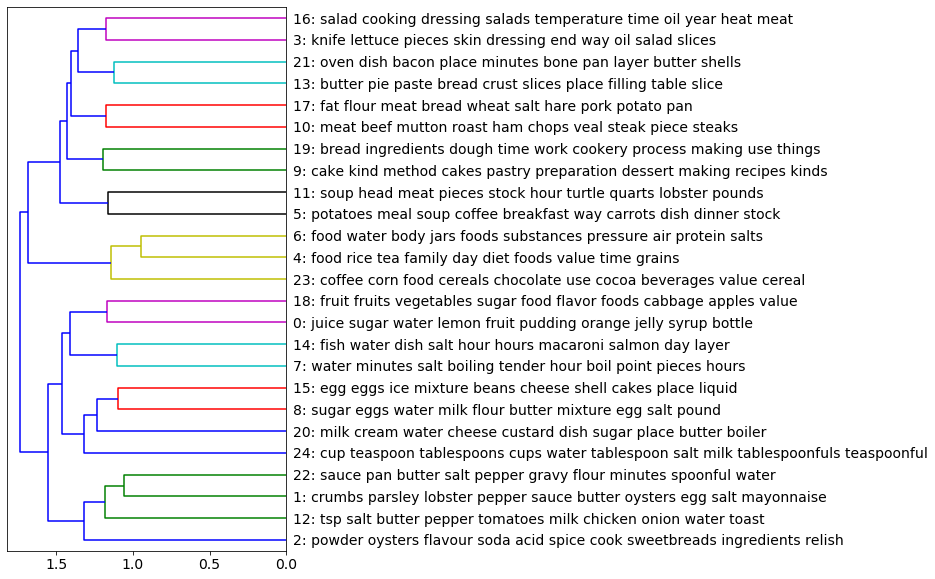

In [38]:
plot_tree(PHI, PERIOD) # same result with Authors

---
# LDA Viz

In [39]:
pyLDAvis.sklearn.prepare(lda, tf, tfv)

/Users/Kobresia/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8      0.195982  0.176583       1        1  9.017828
22     0.256275 -0.050572       2        1  7.046431
7      0.132024  0.023617       3        1  6.101163
18    -0.178936  0.112056       4        1  4.966384
6     -0.186486  0.029776       5        1  4.949775
10    -0.028549 -0.212927       6        1  4.281335
24     0.219437  0.219737       7        1  4.133591
19    -0.199495 -0.026449       8        1  3.986341
15    -0.100961  0.111456       9        1  3.719563
1      0.222308 -0.039085      10        1  3.659077
9     -0.212680  0.038313      11        1  3.560395
12     0.163540  0.022723      12        1  3.542368
20    -0.012395  0.150498      13        1  3.533921
3      0.098396 -0.020564      14        1  3.524370
17    -0.003336 -0.100539      15        1  3.437046
11     0.069481 -0.185987      16        1  3.435076
23    -0.197814  0.051106      17        1  3.405888
4     -0.204653 -0.027910      18        1  3.342128
14     0.070304 -0.091503      19        1  3.225308
16    -0.159692 -0.043955      20        1  3.203485
13     0.018177 -0.061823      21        1  3.059255
0      0.000671  0.128924      22        1  3.001058
5     -0.087767 -0.005949      23        1  2.985690
21     0.073542 -0.151227      24        1  2.791005
2      0.052626 -0.046301      25        1  2.091519, topic_info=     Category         Freq    Term        Total  loglift  logprob
2766  Default  2469.000000    milk  2469.000000  30.0000  30.0000
1145  Default  1300.000000     cup  1300.000000  29.0000  29.0000
4868  Default  4711.000000   water  4711.000000  28.0000  28.0000
2707  Default  1768.000000    meat  1768.000000  27.0000  27.0000
4701  Default   793.000000     tsp   793.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
1943  Topic25    26.645654     gas   170.267975   2.0125  -5.1471
4516  Topic25    31.672810   taste   402.229921   1.3257  -4.9743
2163  Topic25    26.363513   herbs   167.791888   2.0165  -5.1577
569   Topic25    29.314484  butter  2439.183730  -0.5541  -5.0516
4875  Topic25    25.989731     way  1178.474975   0.0530  -5.1720

[1762 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0        21  0.799577  abbreviations
3         9  0.055851     absorption
3        11  0.055851     absorption
3        15  0.055851     absorption
3        18  0.055851     absorption
...     ...       ...            ...
4996     20  0.914433             yr
4997     24  0.802590           zest
4999      1  0.165477        éclairs
4999     11  0.744647        éclairs
4999     20  0.041369        éclairs

[7370 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 23, 8, 19, 7, 11, 25, 20, 16, 2, 10, 13, 21, 4, 18, 12, 24, 5, 15, 17, 14, 1, 6, 22, 3])

---
# Output

In [40]:
%whos DataFrame

Variable   Type         Data/Info
---------------------------------
AUTHORS    DataFrame    author_last    Boland   B<...>ups water tablespoon...  
DOC        DataFrame           book_id  vol_num  <...>n[17176 rows x 6 columns]
LIB        DataFrame            author_last      <...>_pg61185.txt  late1800s  
PARAS      DataFrame                             <...>n[14846 rows x 1 columns]
PERIOD     DataFrame    period       1900s  late1<...>ups water tablespoon...  
PHI        DataFrame    term_str  abbreviations  <...>n[25 rows x 5000 columns]
THETA      DataFrame    topic_id                 <...>[14846 rows x 25 columns]
TOKENS     DataFrame            book_id  vol_num <...>958460 rows x 12 columns]
TOPICS     DataFrame    term_str         0       <...>lesp...      634.165989  


## PARAS

In [41]:
PARAS.head()

para_str
book_id chap_num recp_num para_num                                                   
9935    1        1.0      0         doubt problem race food order person life body...
                 2.0      0         principles cooking food refers preparation foo...
                 3.0      0         providing food home matter lot housewife fact ...
                 4.0      0         factor problem food housewife distinction wast...
                          1         connection problem waste leakage household cau...

## TOPICS

In [42]:
TOPICS.head()

term_str,0,1,2,3,4,5,6,7,8,9,label,doc_weight_sum
topic_id,,,,,,,,,,,,
0,juice,sugar,water,lemon,fruit,pudding,orange,jelly,syrup,bottle,0 juice sugar water lemon fruit pudding orange...,544.136575
1,crumbs,parsley,lobster,pepper,sauce,butter,oysters,egg,salt,mayonnaise,1 crumbs parsley lobster pepper sauce butter o...,522.547211
2,powder,oysters,flavour,soda,acid,spice,cook,sweetbreads,ingredients,relish,2 powder oysters flavour soda acid spice cook ...,463.351302
3,knife,lettuce,pieces,skin,dressing,end,way,oil,salad,slices,3 knife lettuce pieces skin dressing end way o...,471.572145
4,food,rice,tea,family,day,diet,foods,value,time,grains,4 food rice tea family day diet foods value ti...,511.401569


## THETA (DOC-TOPIC)

In [43]:
THETA.head()

topic_id                                  0         1         2         3   \
book_id chap_num recp_num para_num                                           
9935    1        1.0      0         0.000714  0.000714  0.000714  0.000714   
                 2.0      0         0.000930  0.000930  0.000930  0.000930   
                 3.0      0         0.000851  0.000851  0.000851  0.000851   
                 4.0      0         0.002000  0.002000  0.002000  0.002000   
                          1         0.000667  0.000667  0.000667  0.000667   

topic_id                                  4         5         6         7   \
book_id chap_num recp_num para_num                                           
9935    1        1.0      0         0.336106  0.000714  0.474861  0.000714   
                 2.0      0         0.208673  0.000930  0.000930  0.000930   
                 3.0      0         0.873089  0.000851  0.000851  0.000851   
                 4.0      0         0.841610  0.002000  0.002000  0.002000   
                          1         0.201665  0.000667  0.469969  0.000667   

topic_id                                  8         9   ...        15  \
book_id chap_num recp_num para_num                      ...             
9935    1        1.0      0         0.000714  0.000714  ...  0.000714   
                 2.0      0         0.000930  0.000930  ...  0.000930   
                 3.0      0         0.000851  0.000851  ...  0.000851   
                 4.0      0         0.002000  0.002000  ...  0.002000   
                          1         0.000667  0.140293  ...  0.000667   

topic_id                                  16        17        18        19  \
book_id chap_num recp_num para_num                                           
9935    1        1.0      0         0.050746  0.000714  0.000714  0.000714   
                 2.0      0         0.000930  0.000930  0.000930  0.522913   
                 3.0      0         0.000851  0.000851  0.000851  0.000851   
                 4.0      0         0.002000  0.112390  0.002000  0.002000   
                          1         0.000667  0.000667  0.000667  0.000667   

topic_id                                  20        21        22        23  \
book_id chap_num recp_num para_num                                           
9935    1        1.0      0         0.000714  0.123286  0.000714  0.000714   
                 2.0      0         0.000930  0.000930  0.000930  0.247949   
                 3.0      0         0.000851  0.000851  0.000851  0.000851   
                 4.0      0         0.002000  0.002000  0.002000  0.002000   
                          1         0.000667  0.000667  0.000667  0.000667   

topic_id                                  24  
book_id chap_num recp_num para_num            
9935    1        1.0      0         0.000714  
                 2.0      0         0.000930  
                 3.0      0         0.000851  
                 4.0      0         0.002000  
                          1         0.000667  

[5 rows x 25 columns]

## PHI (TOPIC-WORD)

In [44]:
PHI.head()

term_str,abbreviations,ability,absence,absorption,abstinence,abundance,acceptation,access,accessory,accident,...,yields,yolk,yolks,yorkshire,young,youth,yr,zest,zinc,éclairs
topic_id,,,,,,,,,,,,,,,,,,,,,
0,0.04,0.040000,0.04,0.040000,0.04,0.040000,0.04,0.04,0.040000,0.04,...,0.04,0.040000,0.040000,0.04,0.04,0.04,0.04,0.04,0.04,0.04
1,0.04,0.044058,0.04,0.040000,0.04,0.040000,0.04,0.04,0.040000,0.04,...,0.04,9.620034,9.255570,0.04,0.04,0.04,0.04,0.04,0.04,0.04
2,0.04,0.040000,0.04,0.040000,2.04,0.324189,1.04,0.04,0.040000,0.04,...,0.04,0.040020,0.040000,0.04,0.04,0.04,0.04,0.04,0.04,0.04
3,0.04,0.040000,0.04,0.040000,0.04,0.040000,0.04,0.04,0.452662,0.04,...,0.04,66.563209,2.937096,0.04,0.04,0.04,0.04,0.04,0.04,0.04
4,0.04,0.040000,0.04,1.205903,0.04,0.040000,0.04,0.04,0.040000,1.04,...,0.04,0.040000,0.040000,0.04,0.04,0.04,0.04,0.04,0.04,0.04


## TOPIC by AUTHORS & PERIOD

In [45]:
AUTHORS.head()

author_last,Boland,Bradley,Goudiss,Hill,Hooper,Kitchiner,Lusk,Murrey,Payne,Randolf,Santiagoe,WIDAS,topterms
topic_id,,,,,,,,,,,,,
0,0.047776,0.063694,0.033665,0.028880,0.074274,0.036485,0.011637,0.021440,0.064039,0.053098,0.056983,0.030347,juice sugar water lemon fruit pudding orange j...
1,0.019747,0.023337,0.012858,0.114163,0.044839,0.043383,0.015057,0.088343,0.046221,0.039623,0.020146,0.016613,crumbs parsley lobster pepper sauce butter oys...
2,0.024149,0.010436,0.010965,0.029148,0.014932,0.074506,0.006639,0.024219,0.030335,0.024414,0.034528,0.012649,powder oysters flavour soda acid spice cook sw...
3,0.015672,0.089802,0.014630,0.072744,0.022481,0.031541,0.014942,0.021649,0.037321,0.034725,0.018057,0.029795,knife lettuce pieces skin dressing end way oil...
4,0.051735,0.023543,0.028403,0.021150,0.027153,0.033938,0.120683,0.026046,0.072481,0.010868,0.042126,0.031946,food rice tea family day diet foods value time...


In [46]:
PERIOD.head()

period,1900s,late1800s,mid1800s,topterms
topic_id,,,,
0,0.031176,0.048733,0.038603,juice sugar water lemon fruit pudding orange j...
1,0.029520,0.039842,0.042903,crumbs parsley lobster pepper sauce butter oys...
2,0.014531,0.025050,0.068121,powder oysters flavour soda acid spice cook sw...
3,0.035479,0.021479,0.031947,knife lettuce pieces skin dressing end way oil...
4,0.031289,0.047761,0.030997,food rice tea family day diet foods value time...


---
# Save

### Document-Term Matrix

In [39]:
with open(data_dir + "tfv.pkl", 'wb') as handle:
                    pickle.dump(tfv, handle)
#load the content
#tfv = pickle.load(open(data_dir + "tfv.pkl", "rb" ) )

# Sparse matrix
sparse.save_npz(data_dir + "tf.npz", tf)
your_matrix_back = sparse.load_npz(data_dir + "tf.npz")

In [78]:
PARAS.to_csv(data_dir + 'PARAS.csv')
THETA.to_csv(data_dir + 'THETA.csv')
PHI.to_csv(data_dir + 'PHI.csv')
TOPICS.to_csv(data_dir + 'TOPICS.csv')

In [80]:
AUTHORS.to_csv(data_dir + 'LDA_AUTHOR.csv')
PERIOD.to_csv(data_dir + 'LDA_PERIOD.csv')